# Visión por Computadora 1

## Trabajo Práctico 1

In [99]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pathlib

### **Parte 1 (imágenes en `/white_patch`)**

**1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.** <br>

**2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.**


In [100]:
def get_brightest_pixels(image, channel, percentile=99):
    """
    Find the brightest pixel value in a specific channel of the image based on the given percentile.
    
    Parameters:
    - image: Input image in RGB format (numpy array)
    - channel: Channel to analyze (0, 1, or 2)
    - percentile: Percentile to consider for brightness

    Returns:
    - Brightest pixels (x, y) in the specified channel
    """
    if channel not in [0, 1, 2]:
        raise ValueError("Channel must be 0 (Red), 1 (Green), or 2 (Blue)")

    # Convert image to float32 for precision
    img_float = image.astype(np.float32)

    # Calculate the percentile values for each channel
    max_value = np.percentile(img_float[:, :, channel], percentile)
    
    # Find the brightest pixels in the specified channel
    mask = img_float[:, :, channel] >= max_value
    coords = np.column_stack(np.where(mask))

    return coords

In [101]:
def white_patch_correction(image, percentile=99):
    """
    Apply white patch color correction to the input image.

    Parameters:
    - image: Input image in RGB
    - percentile: Percentile value to determine the white point

    Returns:
    - Corrected image in RGB
    """
    
    # Convert image to float32 for precision
    img_float = image.astype(np.float32)

    # Calculate the percentile values for each channel
    r_max = np.percentile(img_float[:, :, 0], percentile)
    g_max = np.percentile(img_float[:, :, 1], percentile)
    b_max = np.percentile(img_float[:, :, 2], percentile)

    # Avoid division by zero
    r_max = r_max if r_max != 0 else 1.0
    g_max = g_max if g_max != 0 else 1.0
    b_max = b_max if b_max != 0 else 1.0

    # Calculate scaling factors
    r_scale = 255.0 / r_max
    g_scale = 255.0 / g_max
    b_scale = 255.0 / b_max

    # Apply scaling
    img_float[:, :, 0] *= r_scale
    img_float[:, :, 1] *= g_scale
    img_float[:, :, 2] *= b_scale

    # Clip values to [0, 255] and convert back to uint8
    corrected_image = np.clip(img_float, 0, 255).astype(np.uint8)

    return corrected_image

In [102]:
def load_image(image_filepath, color_space='RGB'):
    """
    Load an image in the specified color space.

    Parameters:
    - image_filepath: Image file path
    - color_space: Color space to convert the image to (options: 'RGB', 'BGR', 'GRAYSCALE')

    Returns:
    - Image in the specified color space
    """
    
    if color_space == 'RGB':
        color = cv.IMREAD_COLOR_RGB
    elif color_space == 'BGR':
        color = cv.IMREAD_COLOR
    elif color_space == 'GRAYSCALE':
        color = cv.IMREAD_GRAYSCALE
    else:
        raise ValueError("Unsupported color space. Use 'RGB', 'BGR' or 'GRAYSCALE'.")

    img = cv.imread(str(image_filepath), color)

    if img is not None:
        print(f"'{image_filepath}' loaded ok\n")
        if color_space == 'GRAYSCALE':
            print(f"Shape:\n  x: {img.shape[1]} px \n  y: {img.shape[0]} px\n  channels: 1")
            plt.imshow(img, cmap='gray')
        else:
            print(f"Shape:\n  x: {img.shape[1]} px \n  y: {img.shape[0]} px\n  channels: {img.shape[2]}")
            plt.imshow(img)

        plt.title('Original image')
        

        return img
    else:
        print(f"Error loading '{image_filepath}'")
    

In [103]:
def plot_color_profiles(image, column_num=0):
    """
    Plot color profiles of the image at a specified column.

    Parameters:
    - image: Input image in RGB
    - column_num: Column number to extract the color profile
    """
    
    if column_num < 0 or column_num >= image.shape[1]:
        column_num = image.shape[1] - 1

    profile_red = image[:, column_num, 0]  # Red channel
    profile_green = image[:, column_num, 1]  # Green channel
    profile_blue = image[:, column_num, 2]  # Blue channel

    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.plot(profile_red, color='red')
    plt.plot(profile_green, color='green')
    plt.plot(profile_blue, color='blue')
    plt.title('Color profile at column ' + str(column_num))
    plt.ylabel('Intensity')

    plt.subplot(2, 1, 2)
    plt.imshow(image)
    plt.axvline(x=column_num, color='yellow', linestyle='--', linewidth=2)
    plt.title('Original image')
    plt.tight_layout()
    plt.show()

In [104]:
def apply_white_patch_and_compare(image, percentile=99):
    """
    Apply white patch correction and compare original and corrected images.

    Parameters:
    - image: Input image in RGB
    - percentile: Percentile value for white patch correction

    Returns:
    - Corrected image in RGB
    """
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original image")

    corrected_image = white_patch_correction(image, percentile=percentile)
    plt.subplot(1, 2, 2)
    plt.imshow(corrected_image)
    plt.title("Corrected image (White patch)")

    return corrected_image

In [105]:
def histograms_compare(image, corrected_image):
    """
    Compare histograms of original and corrected images.

    Parameters:
    - image: Original image in RGB
    - corrected_image: Corrected image in RGB
    """
    
    # Histograms original vs corrected
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Original
    histograms_original = []
    for i in range(3):
        hist, _ = np.histogram(image[:, :, i].ravel(), bins=256, range=(0, 256))
        histograms_original.append(hist)

    max_freq_original = max(hist.max() for hist in histograms_original)

    for i, color in enumerate(['red', 'green', 'blue']):
        axes[0, i].hist(image[:, :, i].ravel(), bins=256, color=color, alpha=0.8)
        axes[0, i].set_title(f'Original - {color.capitalize()} channel')
        axes[0, i].set_xlabel('Pixel intensity')
        axes[0, i].set_ylabel('Frequency')
        axes[0, i].set_xlim([0, 256])
        axes[0, i].set_ylim([0, max_freq_original * 1.05])
        axes[0, i].grid(alpha=0.3)

    # Corrected
    histograms_corrected = []
    for i in range(3):
        hist, _ = np.histogram(corrected_image[:, :, i].ravel(), bins=256, range=(0, 256))
        histograms_corrected.append(hist)

    max_freq_corrected = max(hist.max() for hist in histograms_corrected)

    for i, color in enumerate(['red', 'green', 'blue']):
        axes[1, i].hist(corrected_image[:, :, i].ravel(), bins=256, color=color, alpha=0.8)
        axes[1, i].set_title(f'Corrected (White patch) - {color.capitalize()} channel')
        axes[1, i].set_xlabel('Pixel intensity')
        axes[1, i].set_ylabel('Frequency')
        axes[1, i].set_xlim([0, 256])
        axes[1, i].set_ylim([0, max_freq_corrected * 1.05])
        axes[1, i].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

## Tests en imágenes de prueba

'material\white_patch\test_blue.png' loaded ok

Shape:
  x: 278 px 
  y: 100 px
  channels: 3


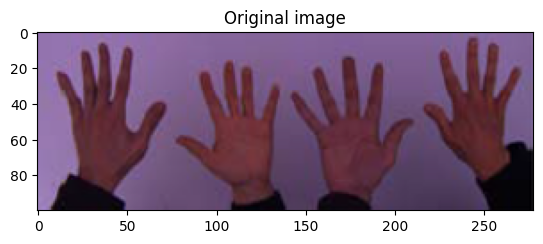

In [106]:
WP_PATH = "material/white_patch/"

img_filename_dict = {
    "0": "test_blue.png",
    "1": "test_green.png",
    "2": "test_red.png",
    "3": "wp_blue.jpg",
    "4": "wp_green.png",
    "5": "wp_green2.jpg",
    "6": "wp_red.png",
    "7": "wp_red2.jpg",
}

test_image = load_image(image_filepath=pathlib.Path(f"{WP_PATH}{img_filename_dict['0']}"), color_space='RGB')

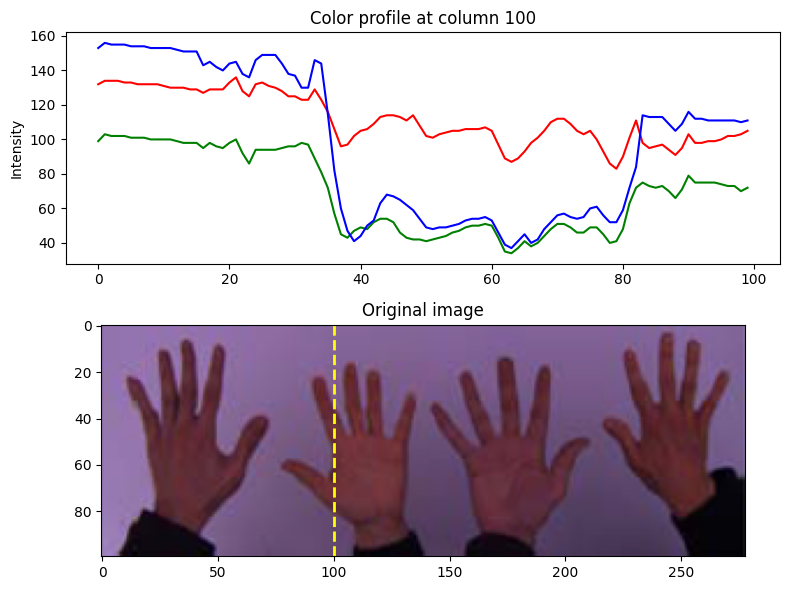

In [107]:
COL = 100  # Column to analyze

plot_color_profiles(test_image, column_num=COL)

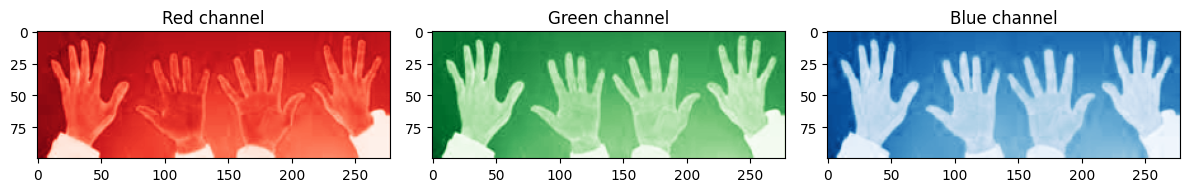

In [108]:
# Plot 3 channels
plt.figure(figsize=(12, 4))

channels = ['Reds', 'Greens', 'Blues']
titles = ['Red channel', 'Green channel', 'Blue channel']

for i, (cmap, title) in enumerate(zip(channels, titles)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_image[:, :, i], cmap=cmap)
    plt.title(title)

plt.tight_layout()
plt.show()

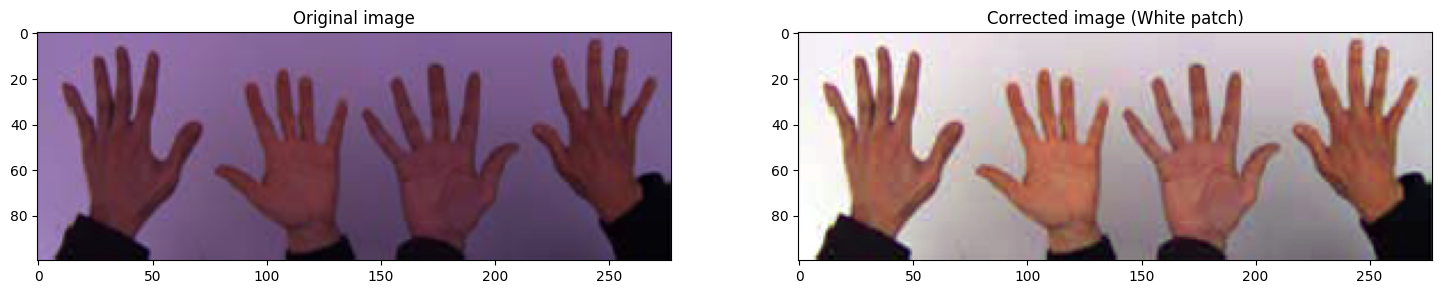

In [109]:
PERCENTILE = 99  # Percentile for white patch correction

corrected_test_image = apply_white_patch_and_compare(test_image, percentile=PERCENTILE)

r_brightest = get_brightest_pixels(test_image, channel=0, percentile=PERCENTILE)
g_brightest = get_brightest_pixels(test_image, channel=1, percentile=PERCENTILE)
b_brightest = get_brightest_pixels(test_image, channel=2, percentile=PERCENTILE)

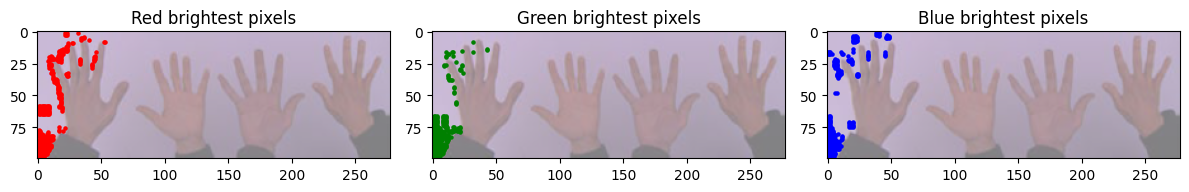

In [110]:
# Plot brightest pixels for each channel
plt.figure(figsize=(12, 4))

channels = ['red', 'green', 'blue']
brightest_pixels = [r_brightest, g_brightest, b_brightest]

for i, (channel, pixels, color) in enumerate(zip(channels, brightest_pixels, channels)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(test_image, alpha=0.5)
    plt.scatter(pixels[:, 1], pixels[:, 0], c=color, s=5)
    plt.title(f"{channel.capitalize()} brightest pixels")

plt.tight_layout()
plt.show()

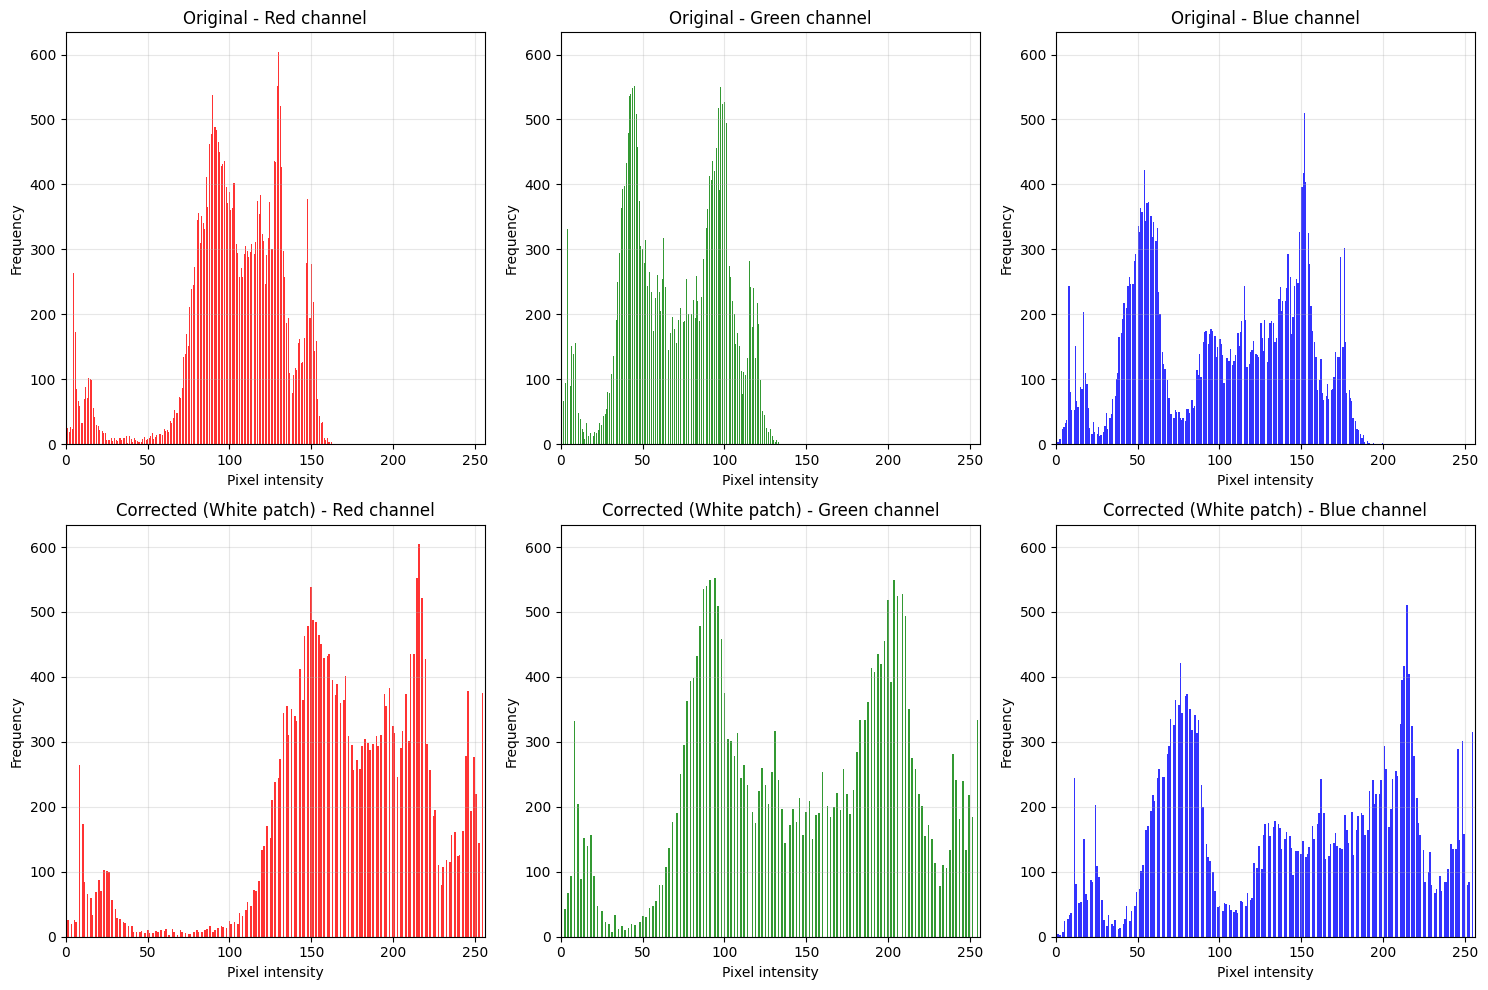

In [111]:
histograms_compare(test_image, corrected_test_image)

#### Imágenes de las manos:
- Probando diferentes percentiles, se observó que con percentiles de 99-99.9% el algoritmo funciona muy bien, ya que logra corregir el tinte sin saturar los canales de color. Sin embargo, percentiles más bajos (<99%) tienden a saturar los canales, lo que resulta en una pérdida de información en esas áreas de la imagen. <br>

#### Imágenes de Depredador:
- En este caso, se encontró que son necesarios percentiles más bajos para corregir la iluminación, y en consecuencia se observa saturación en los canales de color. Esto se debe a que el algoritmo White patch asume que la escena contiene al menos un pixel blanco puro, lo cual no es el caso en estas imágenes, que tienen iluminación dominante muy fuerte.

## Conclusiones Parte 1
**Es clave la correcta elección del percentil para el buen funcionamiento del algoritmo White patch, ya que para percentiles bajos se terminan saturando los canales, generando perdida de información. Existen casos donde el algoritmo no llega a corregir el tinte de manera efectiva, en aquellas imágenes que presentan colores dominantes fuertes.**

---

### **Parte 2**

**1. Para las imágenes `img1_tp.png` y `img2_tp.png`, leerlas con OpenCV en escala de grises y visualizarlas.** <br>

**2. Elija el número de bins que crea conveniente y grafique su histograma. Compare los histogramas entre sí. Explique lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, ¿considera que puede ser de utilidad tomar como 'features' los histogramas?**


'material\img1_tp.png' loaded ok

Shape:
  x: 287 px 
  y: 288 px
  channels: 1


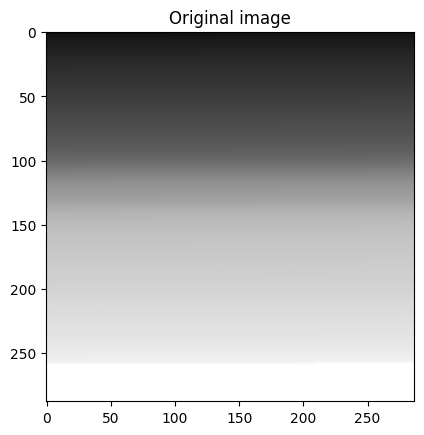

In [112]:
IMG1_PATH = pathlib.Path("material/img1_tp.png")
img1 = load_image(IMG1_PATH, color_space='GRAYSCALE')

'material\img2_tp.png' loaded ok

Shape:
  x: 287 px 
  y: 288 px
  channels: 1


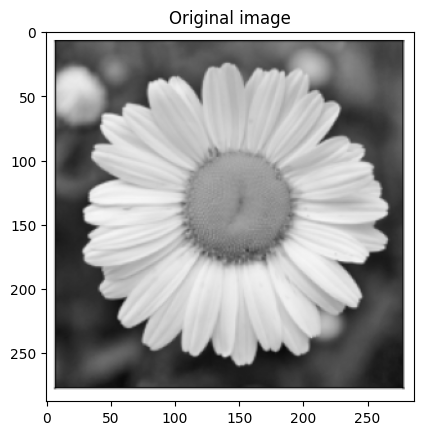

In [113]:
IMG2_PATH = pathlib.Path("material/img2_tp.png")
img2 = load_image(IMG2_PATH, color_space='GRAYSCALE')

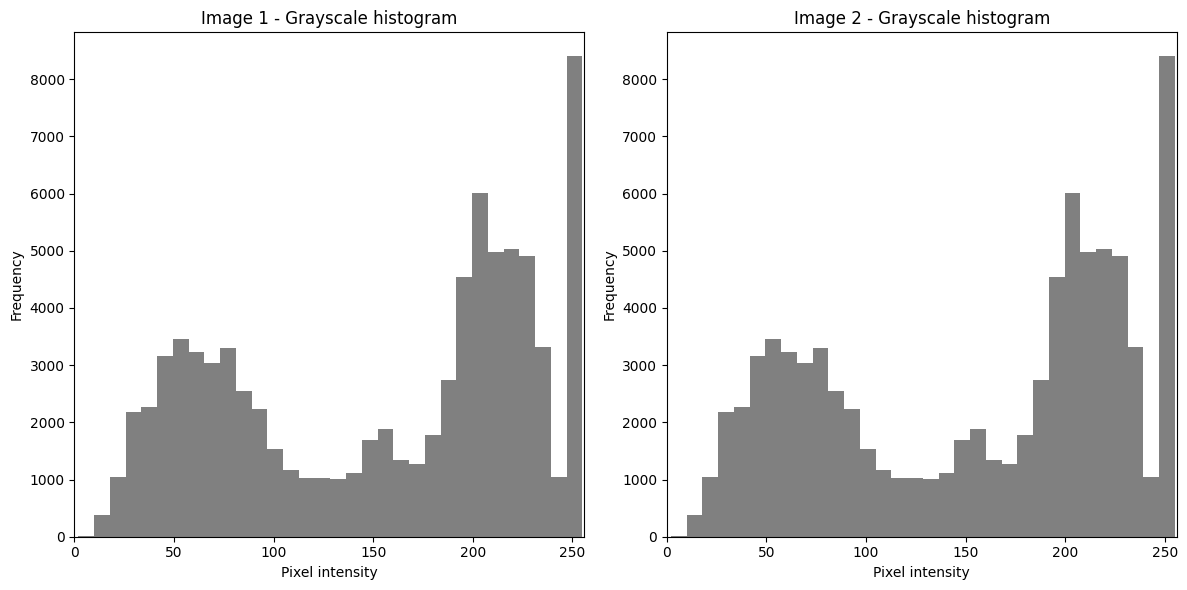

In [114]:
# Histograms comparison
BINS = 32

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, (img, title) in enumerate([(img1, 'Image 1'), (img2, 'Image 2')]):
    axes[idx].hist(img.ravel(), bins=BINS, color='gray', alpha=1)
    axes[idx].set_title(f'{title} - Grayscale histogram')
    axes[idx].set_xlim([0, 256])
    axes[idx].set_xlabel('Pixel intensity')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Tests en imágenes de prueba

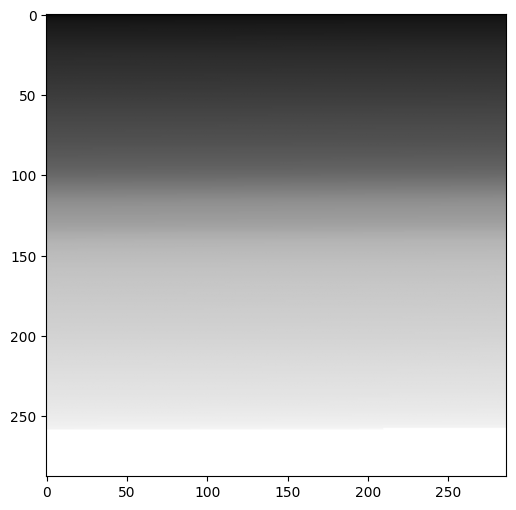

In [119]:
# Sort image 2 pixels and sort them
sorted_pixels = np.sort(img2.ravel())
plt.figure(figsize=(8, 6))
plt.imshow(sorted_pixels.reshape(img2.shape), cmap='gray')

In [ ]:
# Is sorted image 2 identical to image 1?
all(sorted_pixels == img1.ravel())

True

## Conclusiones Parte 2
**Si bien las imágenes son visualmente diferentes los histogramas son idénticos, lo que indica que la distribución de intensidades es la misma. <br>
Se hizo una prueba de ordenamiento de los píxeles de la segunda imagen y se comparó con la primera imagen, resultando ser idénticas. Esto confirma que ambas imágenes contienen los mismos valores de intensidad, pero distribuidos de manera diferente. <br>
En conclusión, para entrenar un modelo de clasificación/detección de imágenes no parece ser conveniente utilizar los histogramas como única característica, ya que no capturan los objetos retratados.**